# Introduction

TODO


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding, Lambda, Concatenate, Reshape
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from keras.models import load_model
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import re
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def build_chars_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [5]:
def vectorize_sentences_data(input_texts, target_labels, max_sents_per_doc, max_words_per_sent, max_chars_per_word, 
                             num_classes, char2int):

    #print(target_labels[0:100])
    '''
    hier_input_data = np.zeros((len(input_texts), 
                                max_sents_per_doc, 
                                max_words_per_sent, 
                                max_chars_per_word), dtype='float32')
    
        
    hier_target_data = np.zeros((len(input_texts), num_classes), dtype='float32')
    '''
    input_data = []
    target_data = []
    if(target_labels == None):
        target_labels = np.zeros(len(input_texts), dtype='int32')
        

    for i, (input_text, target_label) in enumerate(zip(input_texts, target_labels)):
        hier_input_data = np.zeros( (max_sents_per_doc, 
                                    max_words_per_sent, 
                                    max_chars_per_word), dtype='float32')


        hier_target_data = np.zeros(num_classes, dtype='float32')        
        #sents_lst = sent_tokenize(clean_str(BeautifulSoup(input_text).get_text())) # TODO: Move to clean str
        sents_lst = sent_tokenize(input_text)
        
        
        if len(sents_lst) > max_sents_per_doc:
            #print('sents_per_doc', len(sents_lst))
            continue
        
        for j, sent in enumerate(sents_lst):
                
            words_lst = word_tokenize(sent)
            
            if(len(words_lst) > max_words_per_sent):
                #print('words_per_sent', len(words_lst))
                continue
            
            
            for k, word in enumerate(words_lst):
                
                
                if(len(word) > max_chars_per_word):
                    #print('chars_per_word', len(word))
                    continue
                
                for l, char in enumerate(word):
                    # c0..cn
                    if(char in char2int):
                        hier_input_data[j, k, l] = char2int[char]
                        try:
                            #print(target_label)
                            hier_target_data[target_label] = 1
                            
                            #print(hier_target_data[i,:])
                        except:
                            print(target_label)
        input_data.append(hier_input_data)
        target_data.append(hier_target_data)
                
    return np.array(input_data), np.array(target_data)

In [6]:
def build_chars2word_model_simple_BiLSTM(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
 
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_word_embedding_model = Model(input=encoder_inputs, output=encoder_embedding_output)

    return encoder_word_embedding_model

In [7]:
def build_words2sent_model_simple_BiLSTM(encoder_word_embedding_model, 
                           max_words_seq_len, 
                           max_char_seq_len, 
                           latent_dim):
    # Define an input sequence and process it.

    inputs = Input(shape=(max_words_seq_len, max_char_seq_len,), dtype='float32')
    #print(inputs.shape)
    input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

    encoder_inputs_ = input_words   
    #encoder_inputs = Input(shape=(None, char_vocab_size))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
        
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_sentence_embedding_model = Model(input=inputs, output=encoder_embedding_output)

    return encoder_sentence_embedding_model

In [8]:
 
def build_sent2doc_model(encoder_sentence_embedding_model, 
                         max_sents_seq_len, 
                         max_words_seq_len, 
                         max_char_seq_len, 
                         word2sent_latent_dim,
                         sent2doc_latent_dim):
    
    inputs = Input(shape=(max_sents_seq_len, max_words_seq_len, max_char_seq_len,), dtype='float32')
    
    sents_states = []
    
    for s in range(max_sents_seq_len):
        
        encoder_words_inputs = Lambda(lambda x: x[:,s,:,:])(inputs)
        #print(encoder_words_inputs.shape)
        encoder_words_outputs = encoder_sentence_embedding_model(encoder_words_inputs)
        encoder_words_outputs = Reshape((1,word2sent_latent_dim*2))(encoder_words_outputs)
        #_, h, c = encoder_sentence_embedding_model(encoder_words_inputs)
        '''
        input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

        encoder_inputs_ = input_words   
        #encoder_inputs = Input(shape=(None, char_vocab_size))
        encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
        encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM

        encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
        '''
        
        
        #encoder_words_states = Concatenate()([h,c])
        #print(encoder_chars_states)
        #encoder_words_states = Reshape((1,word2sent_latent_dim*4))(encoder_words_states)
        #print(encoder_words_outputs.shape)
        sents_states.append(encoder_words_outputs)
    #print(sents_states)
    input_sents = Concatenate(axis=-2)(sents_states)
    #print(input_sents.shape)
    encoder_inputs_ = input_sents   
    encoder = Bidirectional(LSTM(sent2doc_latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    
    encoder_document_embedding_model = Model(input=inputs, output=encoder_embedding_output)
    '''
    preds = Dense(2, activation='softmax')(encoder_embedding_output)
    model = Model(inputs, preds)
    '''
    #return model, encoder_document_embedding_model
    return encoder_document_embedding_model

In [9]:
def build_hier_senti_model(encoder_document_embedding_model,
                           max_sents_seq_len, 
                           max_words_seq_len, 
                           max_char_seq_len):
    inputs = Input(shape=(max_sents_seq_len, max_words_seq_len, max_char_seq_len,), dtype='float32')
    encoder_embedding_output = encoder_document_embedding_model(inputs)
    preds = Dense(2, activation='softmax')(encoder_embedding_output)
    model = Model(inputs, preds)
    return model

In [10]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

# Data loading and analysis

## Load data

In [11]:
data_path = '../../dat/'


In [12]:
data_file = 'imdb/labeledTrainData.tsv'
data_train = pd.read_csv(os.path.join(data_path, data_file), sep='\t')
print(data_train.shape)
data_train.head()

(25000, 3)


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [13]:
data_train = data_train[:1000]

In [14]:
data_file = 'imdb/testData.tsv'
data_test = pd.read_csv(os.path.join(data_path, data_file), sep='\t')
print(data_test.shape)
data_test.head()

(25000, 2)


,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [15]:
data_test = data_test[:1000]

In [16]:
data_train.review

0      With all this stuff going down at the moment w...
1      \The Classic War of the Worlds\" by Timothy Hi...
2      The film starts with a manager (Nicholas Bell)...
3      It must be assumed that those who praised this...
4      Superbly trashy and wondrously unpretentious 8...
5      I dont know why people think this is such a ba...
6      This movie could have been very good, but come...
7      I watched this video at a friend's house. I'm ...
8      A friend of mine bought this film for £1, and ...
9      <br /><br />This movie is full of references. ...
10     What happens when an army of wetbacks, towelhe...
11     Although I generally do not like remakes belie...
12     \Mr. Harvey Lights a Candle\" is anchored by a...
13     I had a feeling that after \Submerged\", this ...
14     note to George Litman, and others: the Mystery...
15     Stephen King adaptation (scripted by King hims...
16     `The Matrix' was an exciting summer blockbuste...
17     Ulli Lommel's 1980 film 

In [17]:
all_texts = data_train.review  + data_test.review

### Histogram of lenghts

In [18]:
#import nltk
#nltk.download('punkt')

In [19]:

chars_per_words_lengths = []
words_per_sents_lengths = []
sents_per_docs_lengths = []

# Chars per word should be on all text

for text in all_texts:
    
    sents = sent_tokenize(clean_str(BeautifulSoup(text).get_text()))
    sents_per_docs_lengths.append(len(sents))
    for sent in sents:       
    
        words = word_tokenize(sent)
        words_per_sents_lengths.append(len(words))
        for word in words:
            chars_per_words_lengths.append(len(word))

    

/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


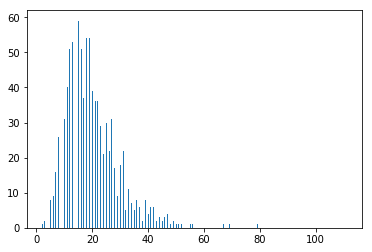

In [20]:
h_s = plt.hist(sents_per_docs_lengths, bins=500)

In [21]:
np.mean(sents_per_docs_lengths)

19.800000000000001

In [22]:
np.max(sents_per_docs_lengths)

111

In [23]:
np.std(sents_per_docs_lengths)

10.45303783595946

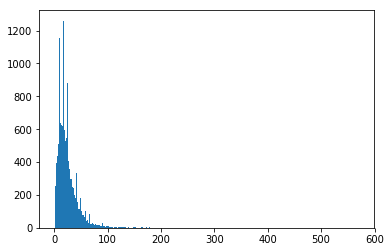

In [24]:
h_w = plt.hist(words_per_sents_lengths, bins=500)

In [25]:
np.mean(words_per_sents_lengths)

25.511868686868688

In [26]:
np.max(words_per_sents_lengths)

571

In [27]:
np.std(words_per_sents_lengths)

21.209876214472867

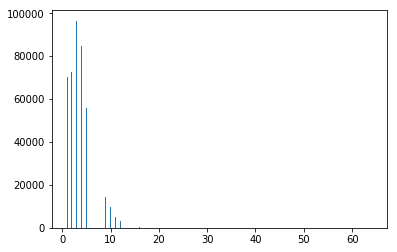

In [28]:
h_c = plt.hist(chars_per_words_lengths, bins=500)

In [29]:
np.mean(chars_per_words_lengths)

4.1639106377503046

In [30]:
np.max(chars_per_words_lengths)

64

In [31]:
np.std(chars_per_words_lengths)

2.5984862894612575

In [32]:
all_texts = list(all_texts.apply(BeautifulSoup).apply(BeautifulSoup.get_text).apply(clean_str))


/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [33]:
train_texts = list(data_train.review.apply(BeautifulSoup).apply(BeautifulSoup.get_text).apply(clean_str))
test_texts = list(data_test.review.apply(BeautifulSoup).apply(BeautifulSoup.get_text).apply(clean_str))

/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


## Build char vocab (all text)

In [34]:

vocab_to_int, int_to_vocab = build_chars_vocab(all_texts)
#np.savez('vocab_char-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )
char2int = vocab_to_int
int2char = int_to_vocab

In [35]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in all_texts])

In [36]:
print('Number of samples:', len(all_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)


Number of samples: 1000
Number of unique input tokens: 108
Number of unique output tokens: 108
Max sequence length for inputs: 13235


In [37]:
#char2int

In [38]:
#int2char

In [39]:
len(int_to_vocab)

108

# Train review model

# Load documents data

In [40]:
MAX_SENTS_PER_DOC = int(np.mean(sents_per_docs_lengths)) + 1
MAX_WORDS_PER_SENT = int(np.mean(words_per_sents_lengths)) + 1
MAX_CHARS_PER_WORD = int(np.mean(chars_per_words_lengths)) + 1

#MAX_SENTS_PER_DOC = 10
#MAX_WORDS_PER_SENT = 40
#MAX_CHARS_PER_WORD = 20
print('MAX_SENTS_PER_DOC = ' + str(MAX_SENTS_PER_DOC) + '\n')
print('MAX_WORDS_PER_SENT = ' + str(MAX_WORDS_PER_SENT) + '\n')
print('MAX_CHARS_PER_WORD = ' + str(MAX_CHARS_PER_WORD) + '\n')

NUM_CLASSES = 2

EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2

MAX_SENTS_PER_DOC = 20

MAX_WORDS_PER_SENT = 26

MAX_CHARS_PER_WORD = 5



# Vectorize documents data

In [41]:
train_input_data, train_targets = vectorize_sentences_data(input_texts=train_texts, 
                                                               target_labels=list(data_train.sentiment), 
                                                               max_sents_per_doc=MAX_SENTS_PER_DOC, 
                                                               max_words_per_sent=MAX_WORDS_PER_SENT, 
                                                               max_chars_per_word=MAX_CHARS_PER_WORD, 
                                                               num_classes=NUM_CLASSES, 
                                                               char2int=char2int)



In [42]:
print(train_targets.sum(axis=0))

[ 457.  413.]


In [43]:
'''for i, t in enumerate(zip(train_texts, list(data_train.sentiment))):
    print(t)
'''


'for i, t in enumerate(zip(train_texts, list(data_train.sentiment))):\n    print(t)\n'

In [44]:
#list(data_train.sentiment)[0:100]

In [45]:
test_input_data, _ = vectorize_sentences_data(input_texts=test_texts, 
                                               target_labels=None, 
                                               max_sents_per_doc=MAX_SENTS_PER_DOC, 
                                               max_words_per_sent=MAX_WORDS_PER_SENT, 
                                               max_chars_per_word=MAX_CHARS_PER_WORD, 
                                               num_classes=NUM_CLASSES, 
                                               char2int=char2int)

In [46]:
train_input_data.shape

(919, 20, 26, 5)

In [47]:
len(train_input_data)

919

In [48]:
train_targets.shape

(919, 2)

In [49]:
test_input_data.shape

(920, 20, 26, 5)

# Build model

In [54]:
char2word_latent_dim = 256
word2sent_latent_dim = 512
sent2doc_latent_dim = 512
char_vocab_size = len(char2int)

#MAX_SENTS_PER_DOC = 21#11
#MAX_WORDS_PER_SENT = 26#24
#MAX_CHARS_PER_WORD = 5
#_, _, _, encoder_word_embedding_model = build_chars2word_model(num_encoder_tokens=char_vocab_size, latent_dim=chars2word_latent_dim)
encoder_word_embedding_model = build_chars2word_model_simple_BiLSTM(num_encoder_tokens=char_vocab_size, latent_dim=char2word_latent_dim)
#print(encoder_word_embedding_model.summary())
'''
_, _, _, encoder_sentence_embedding_model = build_words2sent_model(encoder_word_embedding_model, 
                                                                   max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                                   max_char_seq_len=MAX_CHARS_PER_WORD,
                                                                   latent_dim=words2sent_latent_dim)
'''
encoder_sentence_embedding_model = build_words2sent_model_simple_BiLSTM(encoder_word_embedding_model, 
                                                                   max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                                   max_char_seq_len=MAX_CHARS_PER_WORD, 
                                                                   latent_dim=word2sent_latent_dim)
#print(encoder_sentence_embedding_model.summary())

encoder_document_embedding_model = build_sent2doc_model(encoder_sentence_embedding_model, 
                                                 max_sents_seq_len=MAX_SENTS_PER_DOC, 
                                                 max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                 max_char_seq_len=MAX_CHARS_PER_WORD, 
                                                 word2sent_latent_dim=word2sent_latent_dim,
                                                 sent2doc_latent_dim=sent2doc_latent_dim)
print(encoder_document_embedding_model.summary())
model = build_hier_senti_model(encoder_document_embedding_model=encoder_document_embedding_model,
                                max_sents_seq_len=MAX_SENTS_PER_DOC, 
                                max_words_seq_len=MAX_WORDS_PER_SENT, 
                                max_char_seq_len=MAX_CHARS_PER_WORD)
print(model.summary())





/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 20, 26, 5)    0                                            
__________________________________________________________________________________________________
lambda_49 (Lambda)              (None, 26, 5)        0           input_11[0][0]                   
__________________________________________________________________________________________________
lambda_50 (Lambda)              (None, 26, 5)        0           input_11[0][0]                   
__________________________________________________________________________________________________
lambda_51 (Lambda)              (None, 26, 5)        0           input_11[0][0]                   
__________________________________________________________________________________________________
lambda_52 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 20, 26, 5)         0         
_________________________________________________________________
model_11 (Model)             (None, 1024)              11253136  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 11,255,186
Trainable params: 11,243,522
Non-trainable params: 11,664
_________________________________________________________________
None


# Train model

In [51]:
batch_size = 32  # Batch size for training.
epochs = 100
lr = 0.00001

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_hier_senti_model-{}-{}.hdf5".format(MAX_SENTS_PER_DOC,MAX_WORDS_PER_SENT,MAX_CHARS_PER_WORD) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]
model.fit(train_input_data, train_targets,
          #validation_data=(test_input_data, test_targets)
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 735 samples, validate on 184 samples
Epoch 1/100
735/735 [==============================] - 181s 247ms/step - loss: 0.6545 - categorical_accuracy: 0.5510 - val_loss: 0.6629 - val_categorical_accuracy: 0.5489

Epoch 00001: val_categorical_accuracy improved from -inf to 0.54891, saving model to best_hier_senti_model-20-26.hdf5
Epoch 2/100
735/735 [==============================] - 98s 133ms/step - loss: 0.6544 - categorical_accuracy: 0.5510 - val_loss: 0.6629 - val_categorical_accuracy: 0.5489

Epoch 00002: val_categorical_accuracy did not improve from 0.54891
Epoch 3/100
735/735 [==============================] - 97s 133ms/step - loss: 0.6544 - categorical_accuracy: 0.5510 - val_loss: 0.6629 - val_categorical_accuracy: 0.5489

Epoch 00003: val_categorical_accuracy did not improve from 0.54891
Epoch 4/100
735/735 [==============================] - 97s 132ms/step - loss: 0.6543 - categorical_accuracy: 0.5510 - val_loss: 0.6628 - val_categorical_accuracy: 0.5489

Epoch 00004: val_

735/735 [==============================] - 69s 94ms/step - loss: 0.6501 - categorical_accuracy: 0.5510 - val_loss: 0.6669 - val_categorical_accuracy: 0.5489

Epoch 00035: val_categorical_accuracy did not improve from 0.54891
Epoch 36/100
735/735 [==============================] - 69s 93ms/step - loss: 0.6496 - categorical_accuracy: 0.5510 - val_loss: 0.6687 - val_categorical_accuracy: 0.5489

Epoch 00036: val_categorical_accuracy did not improve from 0.54891
Epoch 37/100
735/735 [==============================] - 69s 93ms/step - loss: 0.6494 - categorical_accuracy: 0.5510 - val_loss: 0.6706 - val_categorical_accuracy: 0.5489

Epoch 00037: val_categorical_accuracy did not improve from 0.54891
Epoch 38/100
735/735 [==============================] - 69s 94ms/step - loss: 0.6492 - categorical_accuracy: 0.5510 - val_loss: 0.6730 - val_categorical_accuracy: 0.5489

Epoch 00038: val_categorical_accuracy did not improve from 0.54891
Epoch 39/100
735/735 [==============================] - 69s 9


Epoch 00069: val_categorical_accuracy did not improve from 0.54891
Epoch 70/100
735/735 [==============================] - 69s 93ms/step - loss: 0.6480 - categorical_accuracy: 0.5510 - val_loss: 0.6955 - val_categorical_accuracy: 0.5489

Epoch 00070: val_categorical_accuracy did not improve from 0.54891
Epoch 71/100
735/735 [==============================] - 69s 93ms/step - loss: 0.6479 - categorical_accuracy: 0.5510 - val_loss: 0.6971 - val_categorical_accuracy: 0.5489

Epoch 00071: val_categorical_accuracy did not improve from 0.54891
Epoch 72/100
735/735 [==============================] - 69s 94ms/step - loss: 0.6480 - categorical_accuracy: 0.5510 - val_loss: 0.6979 - val_categorical_accuracy: 0.5489

Epoch 00072: val_categorical_accuracy did not improve from 0.54891
Epoch 73/100
735/735 [==============================] - 69s 93ms/step - loss: 0.6479 - categorical_accuracy: 0.5510 - val_loss: 0.6968 - val_categorical_accuracy: 0.5489

Epoch 00073: val_categorical_accuracy did not i

# Predict from train

In [52]:
for i, rev in enumerate(train_texts):
    print(rev)
    train_input = train_input_data[i].copy()
    train_input = np.reshape(train_input, (1,train_input.shape[0], train_input.shape[1], train_input.shape[2]))
    prediction = model.predict(train_input)
    print('Prediction: ', prediction)
    sentiment = np.argmax(prediction)
    print('Sentiment: ' + str(sentiment))
    

with all this stuff going down at the moment with mj ive started listening to his music, watching the odd documentary here and there, watched the wiz and watched moonwalker again. maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. some of it has subtle messages about mjs feeling towards the press and also the obvious message of drugs are bad mkay.visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring. some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of him.the actual feature film bit when it finally starts is only on for 20 minute

NameError: name 'test_input' is not defined

# Test model

In [ ]:
for i, rev in enumerate(test_texts):
    print(rev)
    test_input = test_input_data[i].copy()
    test_input = np.reshape(test_input, (1,test_input.shape[0], test_input.shape[1], test_input.shape[2]))
    prediction = model.predict(test_input)
    print('Prediction: ', prediction)
    sentiment = np.argmax(prediction)
    print('Sentiment: ' + str(sentiment))
    